### Загрузка данных

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from utils import get_meta
import matplotlib.image as mpimg

db = "wiki"
# db = "imdb"
mat_path = f"data/{db}_crop/{db}.mat"
full_path, dob, gender, photo_taken, face_score, second_face_score, age, name = get_meta(mat_path, db)

### Общая информация о имиджсете

In [2]:
print ("всего картинок", full_path.shape)
print (f"пример инфо картинки 1: возраст {age[1]}, имя {name[1]}, пол {gender[1]}")
print (f"пример инфо картинки 100: возраст {age[100]}, имя {name[100]}, пол {gender[100]}")
print (f"фотографий без лица: {np.isinf(face_score).sum()}")
print (f"фотографий с face score > 0 во всем датасете {len(face_score[face_score>0])}")
print (f"фотографий с face score > 1 во всем датасете {len(face_score[face_score>1])}")

всего картинок (62328,)
пример инфо картинки 1: возраст 39, имя ['Dettmar Cramer'], пол 1.0
пример инфо картинки 100: возраст 23, имя ['Barbara Steele'], пол 0.0
фотографий без лица: 18016
фотографий с face score > 0 во всем датасете 44312
фотографий с face score > 1 во всем датасете 42993


### Распределение по face score и инфо о second_score

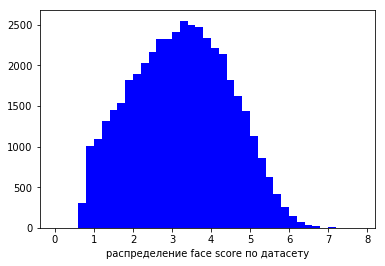

In [3]:
hist = plt.hist(face_score[face_score>0], bins=np.arange(0, 8, 0.2), color='b')
plt.xlabel("распределение face score по датасету")

In [4]:
print(f"картинок со вторым лицом на фото: {(~np.isnan(second_face_score)).sum()}")

картинок со вторым лицом на фото: 4096


### Примеры картинок по face_score

In [5]:
path_root = "data/{}_crop/".format(db)

def show_imgs(img_paths, cols, rows):
    img_ids = np.random.choice(len(img_paths), cols*rows, replace=False)

    for i, img_id in enumerate(img_ids):
        plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(path_root + str(img_paths[img_id]))
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

картинок с face score < 0 : 18016


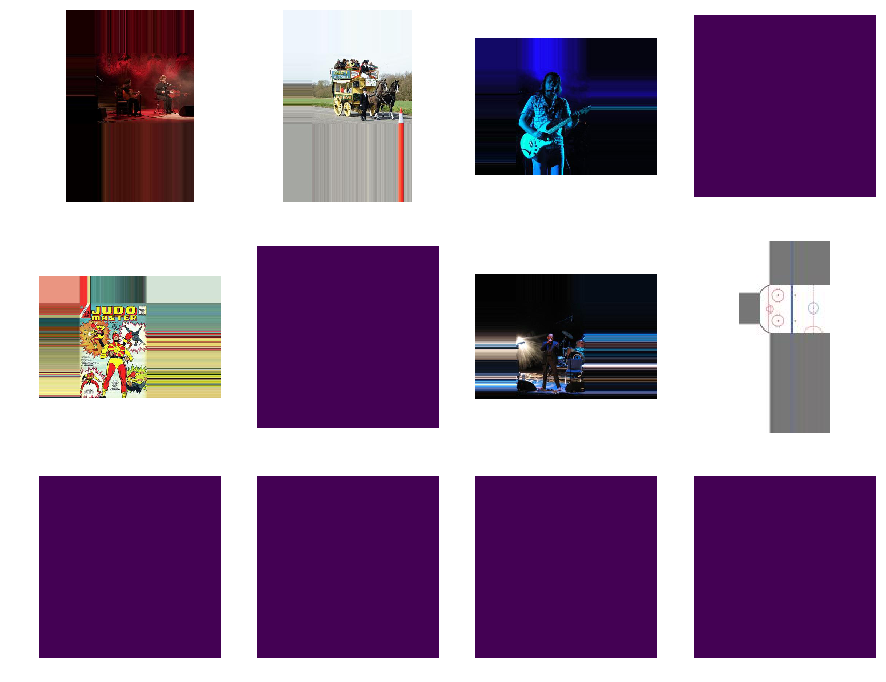

In [29]:
img_paths = []

for i in range(len(face_score)):
    if face_score[i] < 0.0:
        img_paths.append(full_path[i][0])

print(f"картинок с face score < 0 : {len(img_paths)}")

plt.figure(figsize=(15,12))
show_imgs(img_paths, 4, 3)

картинок с face score от 0.1 до 1.5 : 4456


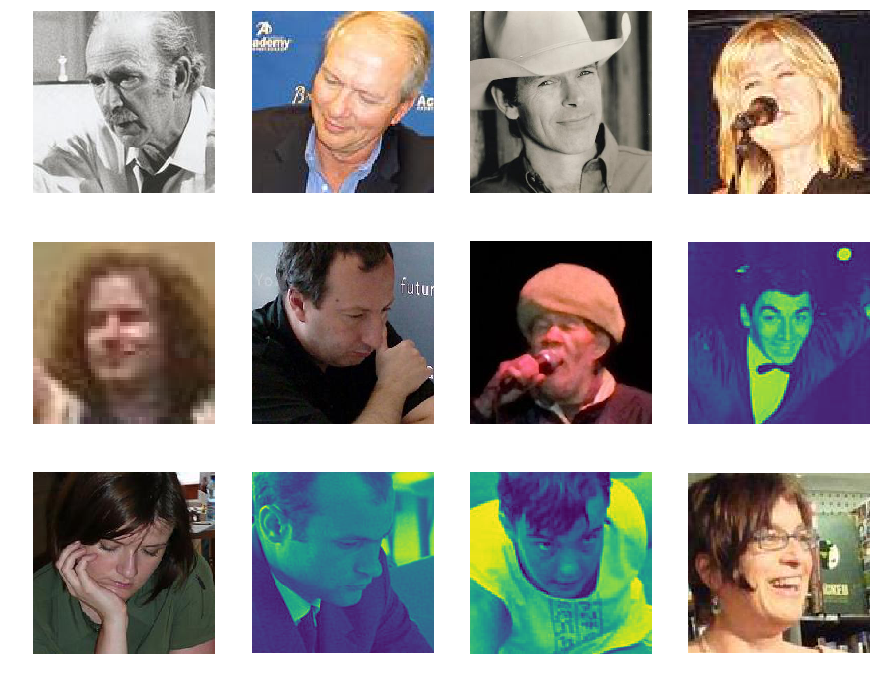

In [35]:
img_paths = []

for i in range(len(face_score)):
    if face_score[i] > 0.1 and face_score[i] < 1.5:
        img_paths.append(full_path[i][0])

print(f"картинок с face score от 0.1 до 1.5 : {len(img_paths)}")

plt.figure(figsize=(15,12))
show_imgs(img_paths, 4, 3)

картинок с face score от 1.5 до 2.5 : 9088


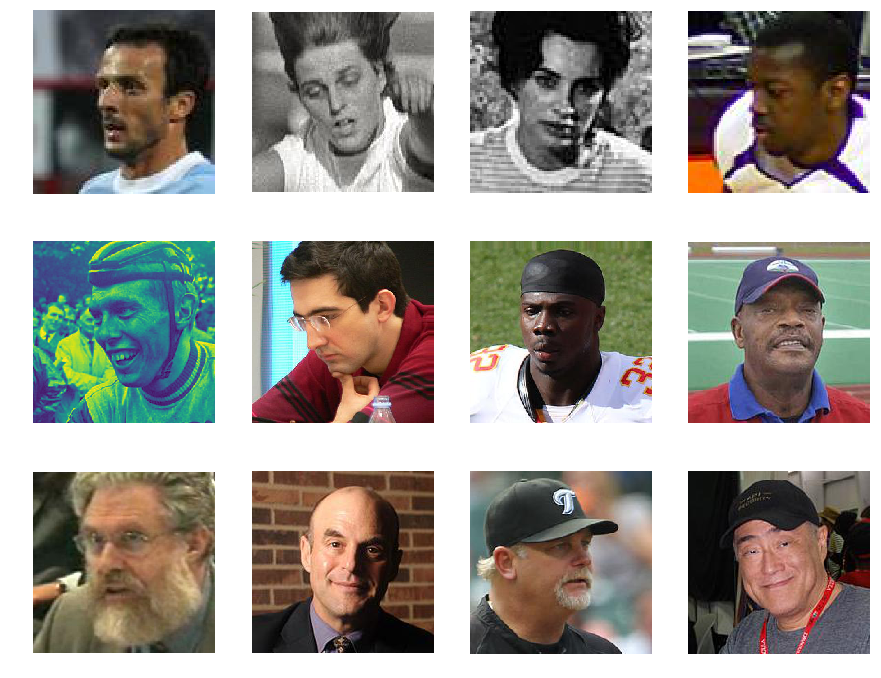

In [24]:
img_paths = []

for i in range(len(face_score)):
    if face_score[i] > 1.5 and face_score[i] < 2.5:
        img_paths.append(full_path[i][0])

print(f"картинок с face score от 1.5 до 2.5 : {len(img_paths)}")

plt.figure(figsize=(15,12))
show_imgs(img_paths, 4, 3)

картинок с face score больше 5 : 3553


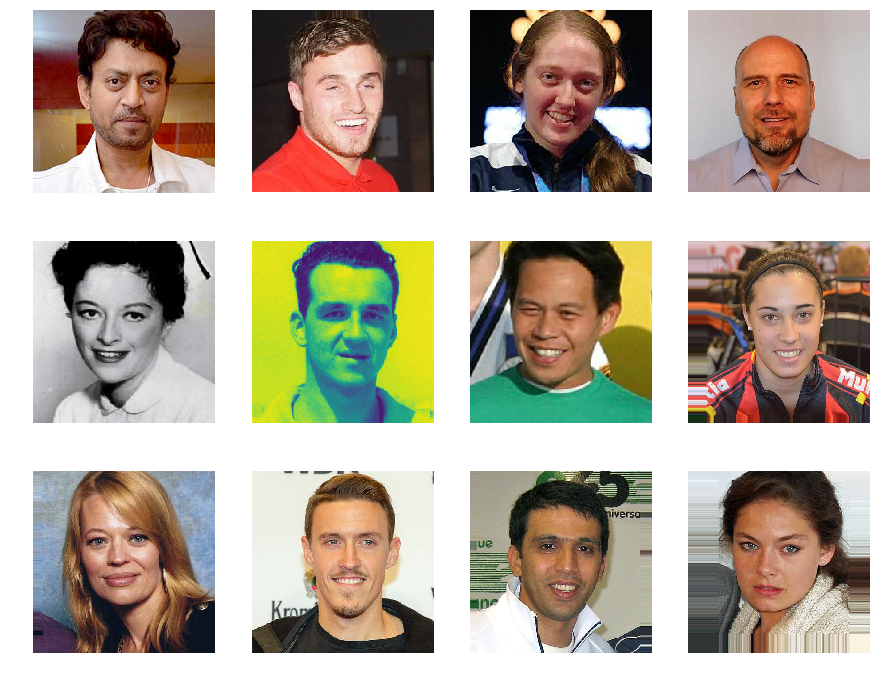

In [23]:
img_paths = []

for i in range(len(face_score)):
    if face_score[i] > 5:
        img_paths.append(full_path[i][0])

print(f"картинок с face score больше 5 : {len(img_paths)}")

plt.figure(figsize=(15,12))
show_imgs(img_paths, 4, 3)

### Картинки по second face score

картинок с second face score от 4 : 164


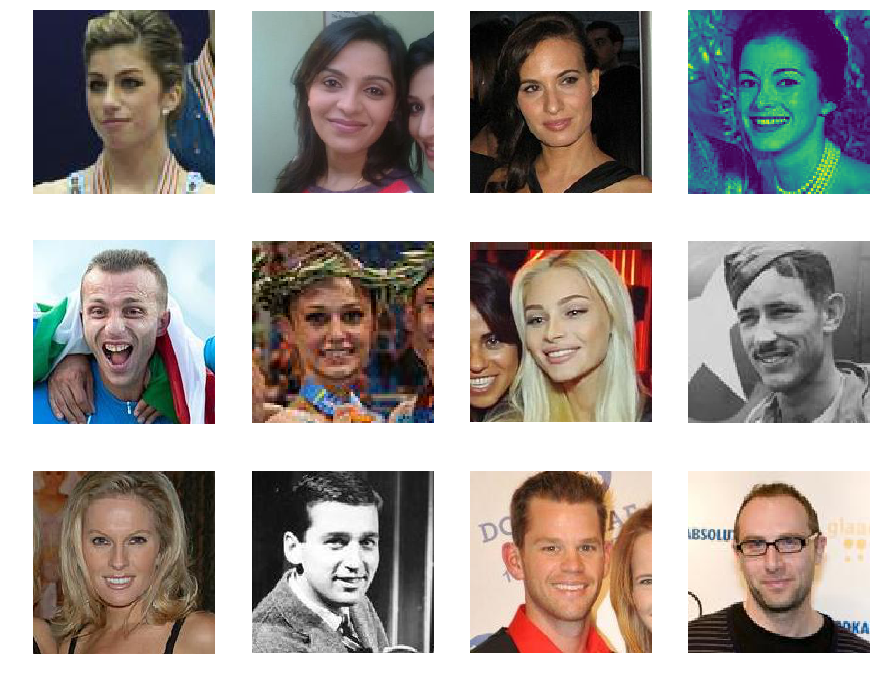

In [22]:
img_paths = []

for i in range(len(second_face_score)):
    if second_face_score[i] > 4:
        img_paths.append(full_path[i][0])

print(f"картинок с second face score от 4 : {len(img_paths)}")

plt.figure(figsize=(15,12))
show_imgs(img_paths, 4, 3)

### Сбор картинок в массивы, сбор массивов категориальных данных и сохранение
#### картинки по критериям собираются в массивы np и сохраняются на диск
#### вместе с ними сохраняется массив данных по полу [man score, woman score]
#### выполняется в IDE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from utils import get_meta
import matplotlib.image as mpimg
from skimage import io
from skimage.transform import rescale, resize
from keras.utils.np_utils import to_categorical

db = "wiki"
mat_path = f"data/{db}_crop/{db}.mat"
imgs_path = f"data/{db}_crop/"
data_path = f"data/{db}_arrays/"
full_path, dob, gender, photo_taken, face_score, second_face_score, age, name = get_meta(mat_path, db)

ending = (len(full_path))
batch_size = 2000
iterations = ending//batch_size+1

for iteration in range(0, iterations+1):
    current_iteration = iteration * batch_size
    last_iteration = current_iteration + batch_size
    if last_iteration > ending:
        last_iteration = ending
    print (f"current iteration {current_iteration} last_iteration {last_iteration}")
    imgs = []
    labels = []
    for counter in range(current_iteration, last_iteration):
        print (counter)
        if face_score[counter] > 0.5 and (gender[counter] == 0 or gender[counter] == 1):
            labels.append(gender[counter])
            img = io.imread(imgs_path + full_path[counter][0])
            img = resize(img, (150,150,3))
            imgs.append(img)
    X = np.array(imgs)
    y = to_categorical(np.array(labels)) #[0, 1] - man, [1, 0] - woman
    print (f'saving arrays, data: {data_path}X_wiki_gender_{iteration}')
    np.save(f'{data_path}X_wiki_gender_{iteration}', X)
    np.save(f'{data_path}/y_wiki_gender_{iteration}', y)

### Собираем модель

In [38]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
import keras.backend as K

In [48]:
K.clear_session()

model_number = 3
db = "wiki"
data_path = f"data/{db}_arrays/"

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=3, input_shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', strides=3, input_shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', strides=3, input_shape=(150, 150, 3)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               102528    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
__________

### Проходим все массивы и на каждом обучаем модель

In [ ]:
for array_num in range(0, arrays_number+1):
    print(f'loading {data_path}X_{db}_gender_{array_num}.npy')
    X = np.load(f'{data_path}X_{db}_gender_{array_num}.npy')
    print(f'loading {data_path}/y_{db}_gender_{array_num}.npy')
    y = np.load(f'{data_path}/y_{db}_gender_{array_num}.npy')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    model.fit(X_train, y_train, 
              epochs=20,
              batch_size=100,
              validation_data=(X_test, y_test))

print (f'saving model models/{db}_model_gender_1.h5')
model.save(f'models/{db}_model_gender_1.h5')

In [ ]:
Epoch 24/30
1233/1233 [==============================] - 1s 771us/step - loss: 0.0262 - acc: 0.9919 - val_loss: 1.2157 - val_acc: 0.7883
Epoch 25/30
1233/1233 [==============================] - 1s 765us/step - loss: 0.0642 - acc: 0.9781 - val_loss: 1.4822 - val_acc: 0.7883
Epoch 26/30
1233/1233 [==============================] - 1s 772us/step - loss: 0.0168 - acc: 0.9951 - val_loss: 1.5146 - val_acc: 0.7445
Epoch 27/30
1233/1233 [==============================] - 1s 766us/step - loss: 0.0452 - acc: 0.9838 - val_loss: 1.5591 - val_acc: 0.7518
Epoch 28/30
1233/1233 [==============================] - 1s 771us/step - loss: 0.0370 - acc: 0.9878 - val_loss: 1.4429 - val_acc: 0.7883
Epoch 29/30
1233/1233 [==============================] - 1s 774us/step - loss: 0.0182 - acc: 0.9943 - val_loss: 1.7646 - val_acc: 0.8029
Epoch 30/30
1233/1233 [==============================] - 1s 769us/step - loss: 0.0179 - acc: 0.9968 - val_loss: 1.7534 - val_acc: 0.7445

### проверка модели

In [53]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

model_number = 3
classifier = load_model(f'models/wiki_model_gender_{model_number}.h5')

def gender(image_num, cat):
    image_name = f"images/{cat}/{image_num}.jpg"
    test_image = image.load_img(image_name, target_size = (150, 150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    predict = classifier.predict(test_image)
#    print (predict)
    if predict[0,0] == 0:
        return 'man'
    else:
        return 'woman'

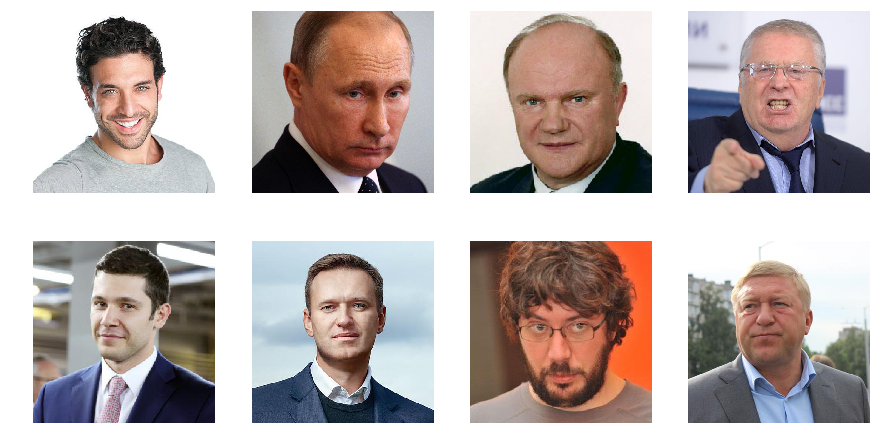

In [46]:
def show_imgs2(img_paths, cols, rows):
    for i, img_id in enumerate(img_paths):
        plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(img_id)
        plt.imshow(img)
        plt.axis('off')

img_paths = []

for i in range(1, 9):
     img_paths.append(f'images/m/{i}.jpg')

plt.figure(figsize=(15,12))
show_imgs2(img_paths, 4, 3)

In [55]:
for i in range(1,9):
    print (f"image {i} is a " +  gender(i, 'm'))

image 1 is a man
image 2 is a man
image 3 is a man
image 4 is a man
image 5 is a man
image 6 is a woman
image 7 is a woman
image 8 is a man


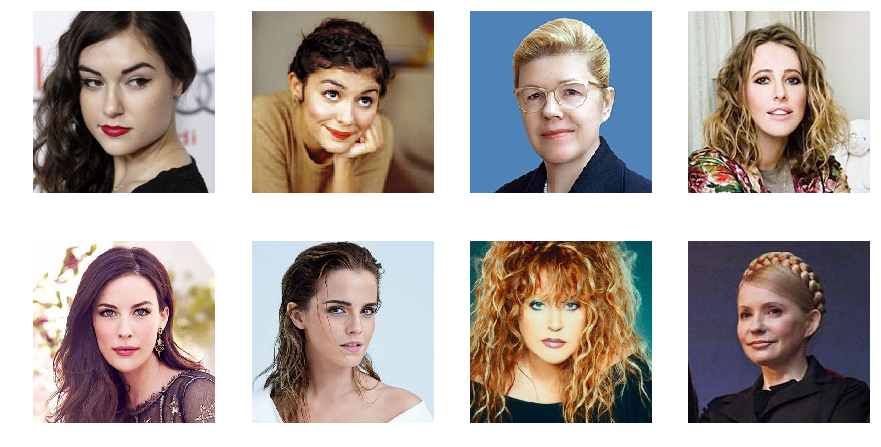

In [58]:
def show_imgs2(img_paths, cols, rows):
    for i, img_id in enumerate(img_paths):
        plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(img_id)
        plt.imshow(img)
        plt.axis('off')

img_paths = []

for i in range(1, 9):
     img_paths.append(f'images/f/{i}.jpg')

plt.figure(figsize=(15,12))
show_imgs2(img_paths, 4, 3)

In [59]:
for i in range(1,9):
    print (f"image {i} is a " +  gender(i, 'f'))

image 1 is a woman
image 2 is a woman
image 3 is a woman
image 4 is a woman
image 5 is a woman
image 6 is a man
image 7 is a woman
image 8 is a man


### Подход 2 - выделение при помощи openCV только лиц

In [21]:
db = "wiki"
array_num = 0
data_path = f"data/{db}_arrays_cropped_faces/"
X = np.load(f'{data_path}images_{db}_{array_num}.npy')

In [ ]:
import cv2
from utils import get_meta, get_face
import numpy as np
from skimage import io
from skimage.transform import resize
from keras.utils.np_utils import to_categorical

def get_face(imagePath):
    '''
    возвращает массив с самым большим лицом на фото
    если лица нет, возвращает []
    '''
    cascPath = "haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.05,
        minNeighbors=5,
        minSize=(50, 50)
    )
    try:
        x_max = faces[0][0]
    except:
        return []
    y_max = faces[0][1]
    w_max = faces[0][2]
    h_max = faces[0][3]
    for (x, y, w, h) in faces:
        if w > w_max:
            x_max = x
            y_max = y
            w_max = w
            h_max = h       
    cropped = image[y_max:y_max+h_max,x_max:x_max+w_max]
    return cropped


db = "imdb"
mat_path = f"data/{db}_crop/{db}.mat"
imgs_path = f"data/{db}_crop/"
data_path = f"data/{db}_arrays_cropped_faces/"
full_path, dob, gender, photo_taken, face_score, second_face_score, age, name = get_meta(mat_path, db)

ending = (len(full_path))
batch_size = 10000
iterations = ending//batch_size+1
image_size = 227

for iteration in range(0, iterations+1):
    current_iteration = iteration * batch_size
    last_iteration = current_iteration + batch_size
    if last_iteration > ending:
        last_iteration = ending
    print (f"current iteration {current_iteration} last_iteration {last_iteration}")
    imgs = []
    gender_labels = []
    age_labels = []
    name_labels = []
    for counter in range(current_iteration, last_iteration):
        print (counter)
        if face_score[counter] > 0.5 and (gender[counter] == 0 or gender[counter] == 1):
            cropped_face = get_face(imgs_path + full_path[counter][0])
            if (len(cropped_face) != 0):
                resized = cv2.resize(cropped_face, (image_size,image_size), interpolation = cv2.INTER_LINEAR)
                gender_labels.append(gender[counter])
                age_labels.append(age[counter])
                name_labels.append(name[counter][0])
                imgs.append(resized)
    img_array = np.array(imgs)
    gender_array = to_categorical(np.array(gender_labels)) #[0, 1] - man, [1, 0] - woman
    age_array = np.array(age_labels)
    print (f'saving arrays, data: {data_path}, iteration: {iteration}')
    np.save(f'{data_path}images_{db}_{iteration}', img_array)
    np.save(f'{data_path}gender_{db}_{iteration}', gender_array)
    np.save(f'{data_path}age_{db}_{iteration}', age_array)
    np.save(f'{data_path}/names_{db}_gender_{iteration}', name_labels)

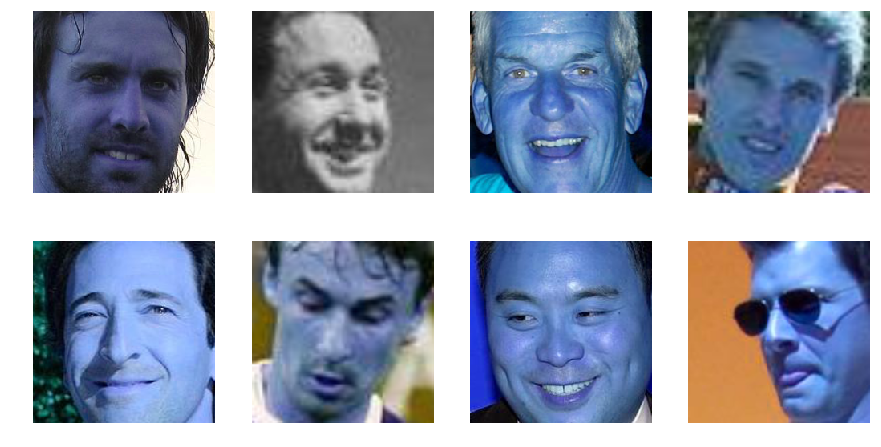

In [31]:
arr = []
for i in range(8):
    arr.append(X[np.random.randint(0, X.shape[0])])
rows = 3
cols = 4
plt.figure(figsize=(15,12))
for i, img in enumerate(arr):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

In [33]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import RMSprop
import numpy as np

arrays_number = 0 #количество массивов.
epochs_number = 8
db = "imdb"
data_path = f"data/{db}_arrays_cropped_faces/"

model_number = '1'

model = Sequential()
model.add(Conv2D(96, (7, 7), strides=4, input_shape=(227, 227, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(256, (5, 5), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

rms = RMSprop(lr = 0.0009)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['accuracy'])

for array_num in range(0, arrays_number+1):
    print(f'loading {data_path}images_{db}_{array_num}.npy')
    X = np.load(f'{data_path}images_{db}_{array_num}.npy')
    print(f'loading {data_path}gender_{db}_{array_num}.npy')
    y = np.load(f'{data_path}gender_{db}_{array_num}.npy')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model.fit(X_train, y_train, 
              epochs=epochs_number,
              batch_size=50,
              validation_data=(X_test, y_test))

loading data/imdb_arrays_cropped_faces/images_imdb_0.npy
loading data/imdb_arrays_cropped_faces/gender_imdb_0.npy
Train on 5810 samples, validate on 1453 samples
Epoch 1/8
5810/5810 [==============================] - 14s 2ms/step - loss: 5.9143 - acc: 0.6320 - val_loss: 5.8016 - val_acc: 0.6401
Epoch 2/8
5810/5810 [==============================] - 13s 2ms/step - loss: 5.9257 - acc: 0.6324 - val_loss: 5.8016 - val_acc: 0.6401
Epoch 3/8
5810/5810 [==============================] - 13s 2ms/step - loss: 5.9257 - acc: 0.6324 - val_loss: 5.8016 - val_acc: 0.6401
Epoch 4/8
5810/5810 [==============================] - 13s 2ms/step - loss: 5.9257 - acc: 0.6324 - val_loss: 5.8016 - val_acc: 0.6401
Epoch 5/8
5810/5810 [==============================] - 13s 2ms/step - loss: 5.9257 - acc: 0.6324 - val_loss: 5.8016 - val_acc: 0.6401
Epoch 6/8
5810/5810 [==============================] - 14s 2ms/step - loss: 5.9257 - acc: 0.6324 - val_loss: 5.8016 - val_acc: 0.6401
Epoch 7/8
5810/5810 [=============